In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [25]:
class Config:
    input_size = 32
    input_shape = [input_size, input_size, 3]
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 256
    num_classes = 10
    num_epochs = 100
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    transformer_units = [
        projection_dim * 2,
        projection_dim
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]

In [26]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [27]:
(train_data, train_labels),(test_data, test_labels)  = keras.datasets.cifar10.load_data()
(train_data.shape, train_labels.shape),(test_data.shape, test_labels.shape)

(((50000, 32, 32, 3), (50000, 1)), ((10000, 32, 32, 3), (10000, 1)))

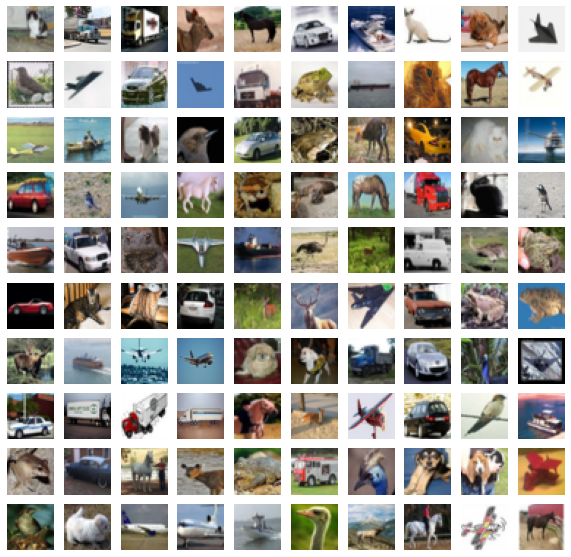

In [28]:
indices = np.random.choice(train_data.shape[0], 100)
sample_images(train_data[indices], 10, 10)

In [29]:
augmentation_layer = tf.keras.Sequential([
    keras.layers.Input(Config.input_shape),
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.experimental.preprocessing.Resizing(Config.image_size, Config.image_size),
    keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
    keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [30]:
augmentation_layer.layers[0].adapt(train_data)

In [31]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [32]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(32, 32, 3)
(1, 72, 72, 3)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


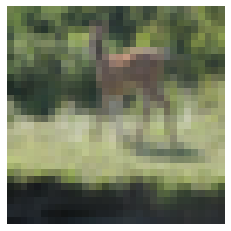

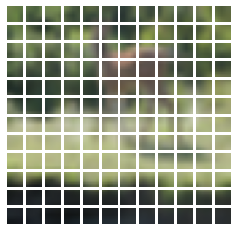

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_data[np.random.choice(range(train_data.shape[0]))]
print(image.shape)
plt.imshow(np.squeeze(image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(Config.image_size, Config.image_size)
)
print(resized_image.shape)
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (Config.patch_size, Config.patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [34]:
class PatchEncoder(layers.Layer):
    
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [35]:
def create_vision_transformer():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    # Patches
    patches = Patches(Config.patch_size)(augmented)
    encoder_patches = PatchEncoder(Config.num_patches, Config.projection_dim)(patches)
    
    for _ in range(Config.transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=Config.num_heads, 
            key_dim=Config.projection_dim,
            dropout=0.1
        )(x1, x1)
        # Skip Connnection 1
        x2 = layers.Add()([attention_output, encoder_patches])
        
        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=Config.transformer_units, dropout_rate=0.1)
        
        # Skip Connnection 2
        encoder_patches = layers.Add()([x3, x2])
    
    representation = layers.LayerNormalization(epsilon=1e-6)(encoder_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=Config.mlp_head_units, dropout_rate=0.5)
    
    outputs = layers.Dense(Config.num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [36]:
keras.backend.clear_session()
vit_classifier = create_vision_transformer()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
patches (Patches)               (None, None, 108)    0           sequential[0][0]                 
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 144, 64)      16192       patches[0][0]                    
______________________________________________________________________________________________

## Training

In [37]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
vit_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)
checkpoint_path = "model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Early stopping and learning rate scheduling
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1
)

In [38]:
history = vit_classifier.fit(
    train_data, train_labels,
    epochs=Config.num_epochs,
    batch_size=Config.batch_size,
    validation_data=(test_data, test_labels),
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/100
196/196 [==============================] - 59s 254ms/step - loss: 2.5412 - accuracy: 0.2546 - val_loss: 1.4552 - val_accuracy: 0.4751
Epoch 2/100
196/196 [==============================] - 49s 248ms/step - loss: 1.5728 - accuracy: 0.4379 - val_loss: 1.2342 - val_accuracy: 0.5481
Epoch 3/100
196/196 [==============================] - 49s 248ms/step - loss: 1.3704 - accuracy: 0.5063 - val_loss: 1.1213 - val_accuracy: 0.5988
Epoch 4/100
196/196 [==============================] - 49s 248ms/step - loss: 1.2538 - accuracy: 0.5526 - val_loss: 1.0940 - val_accuracy: 0.6106
Epoch 5/100
196/196 [==============================] - 49s 248ms/step - loss: 1.1773 - accuracy: 0.5866 - val_loss: 1.0060 - val_accuracy: 0.6446
Epoch 6/100
196/196 [==============================] - 49s 248ms/step - loss: 1.0975 - accuracy: 0.6131 - val_loss: 0.9426 - val_accuracy: 0.6636
Epoch 7/100
196/196 [==============================] - 49s 248ms/step - loss: 1.0433 - accuracy: 0.6328 - val_loss: 0.9360 -

<AxesSubplot:>

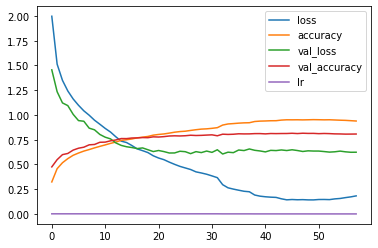

In [39]:
pd.DataFrame(history.history).plot()

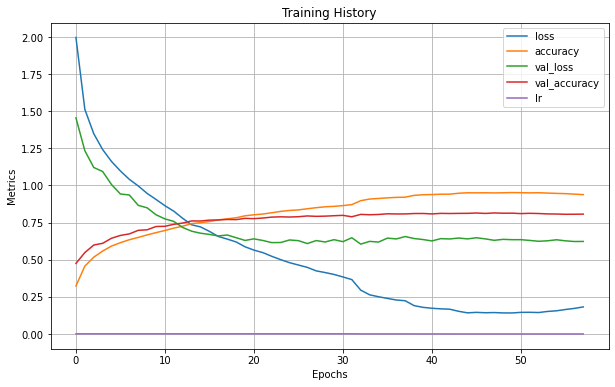

313/313 [==============================] - 6s 18ms/step - loss: 0.6307 - accuracy: 0.8150
Test Loss: 0.6307
Test Accuracy: 0.8150
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.87      0.84      1000
     Class 1       0.92      0.89      0.90      1000
     Class 2       0.82      0.69      0.75      1000
     Class 3       0.65      0.66      0.66      1000
     Class 4       0.79      0.82      0.81      1000
     Class 5       0.73      0.70      0.71      1000
     Class 6       0.82      0.88      0.85      1000
     Class 7       0.85      0.86      0.86      1000
     Class 8       0.90      0.88      0.89      1000
     Class 9       0.84      0.90      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.81      0.81     10000



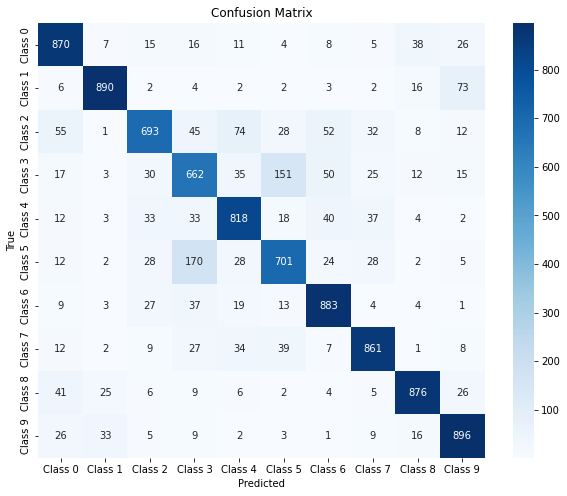

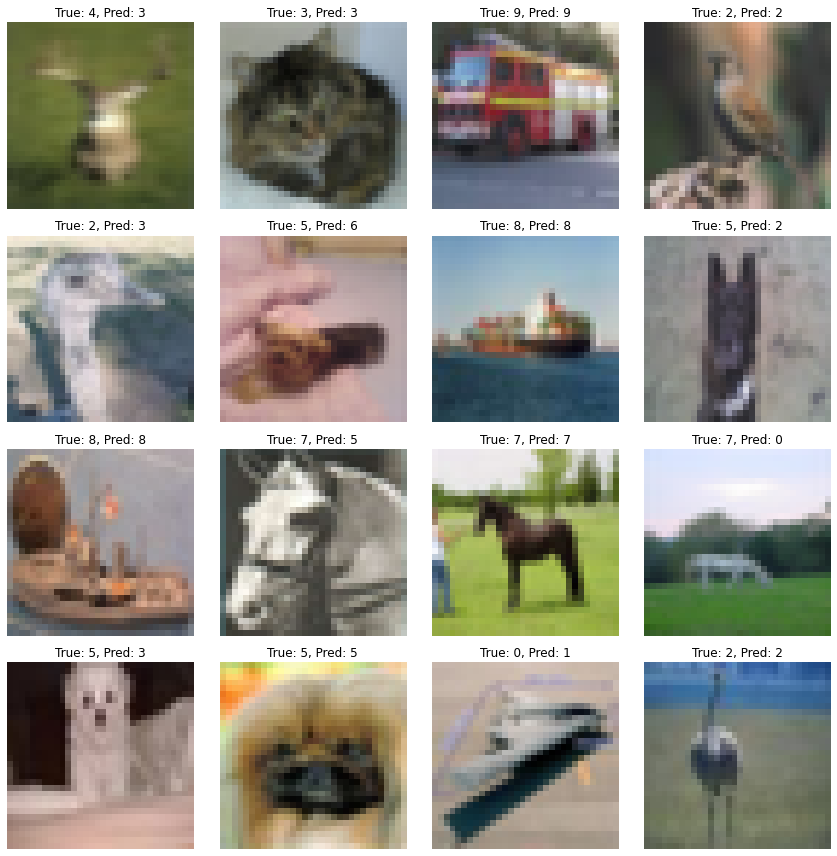

In [40]:
# Plot training history
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.grid()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = vit_classifier.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred = tf.argmax(vit_classifier.predict(test_data), axis=1).numpy()
y_true = test_labels.flatten()

# Classification Report
report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(Config.num_classes)])
print("Classification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=[f"Class {i}" for i in range(Config.num_classes)],
            yticklabels=[f"Class {i}" for i in range(Config.num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Visualize some test images with predictions
num_images = 16
indices = np.random.choice(test_data.shape[0], num_images)
sample_images = test_data[indices]
sample_labels = y_true[indices]
sample_preds = y_pred[indices]

plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.title(f"True: {sample_labels[i]}, Pred: {sample_preds[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 72, 72, 3)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 72, 72, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 256)       295168

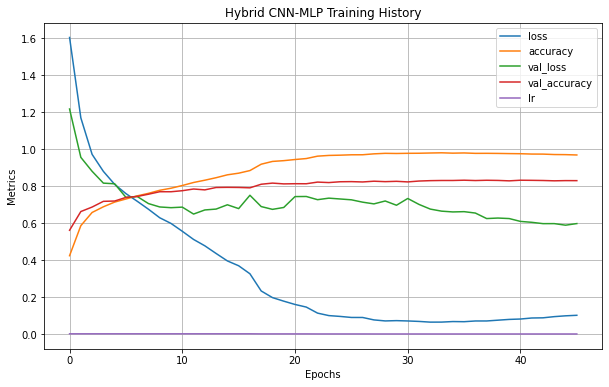

In [41]:
def create_hybrid_cnn_mlp():
    # Inputs
    inputs = layers.Input(shape=Config.input_shape)
    
    # Data Augmentation
    augmented = augmentation_layer(inputs)
    
    # Feature extraction using CNN
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(augmented)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten CNN outputs
    flattened = layers.Flatten()(x)
    
    # MLP Head
    mlp_features = mlp(flattened, hidden_units=Config.mlp_head_units, dropout_rate=0.5)
    
    # Output Layer
    outputs = layers.Dense(Config.num_classes)(mlp_features)
    
    # Model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Clear session and create hybrid model
keras.backend.clear_session()
hybrid_cnn_mlp_model = create_hybrid_cnn_mlp()
hybrid_cnn_mlp_model.summary()

# Compile the model
optimizer = tfa.optimizers.AdamW(
    learning_rate=Config.learning_rate,
    weight_decay=Config.weight_decay
)
hybrid_cnn_mlp_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Training the hybrid model
checkpoint_path_hybrid = "hybrid_model.h5"
checkpoint_hybrid = keras.callbacks.ModelCheckpoint(
    checkpoint_path_hybrid,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

history_hybrid = hybrid_cnn_mlp_model.fit(
    train_data, train_labels,
    epochs=Config.num_epochs,
    batch_size=Config.batch_size,
    validation_data=(test_data, test_labels),
    callbacks=[checkpoint_hybrid, early_stopping, lr_scheduler]
)

# Evaluate the hybrid model
test_loss_hybrid, test_accuracy_hybrid = hybrid_cnn_mlp_model.evaluate(test_data, test_labels)
print(f"Hybrid Model Test Loss: {test_loss_hybrid:.4f}")
print(f"Hybrid Model Test Accuracy: {test_accuracy_hybrid:.4f}")

# Compare with ViT
print(f"ViT Test Accuracy: {test_accuracy:.4f}")
print(f"Hybrid Model Test Accuracy: {test_accuracy_hybrid:.4f}")

# Visualize Training History
pd.DataFrame(history_hybrid.history).plot(figsize=(10, 6))
plt.title("Hybrid CNN-MLP Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.grid()
plt.show()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

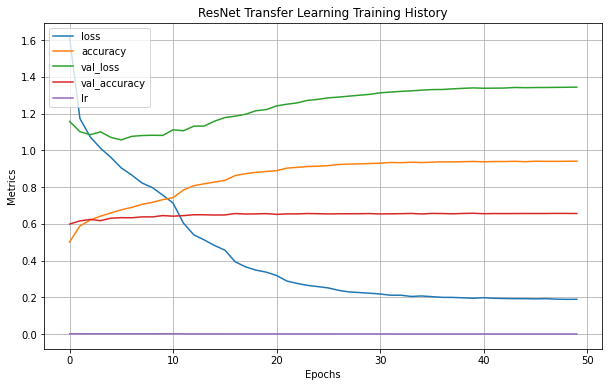

In [42]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

# Load the ResNet50 model pretrained on ImageNet
base_model = ResNet50(
    weights="imagenet",  # Load weights trained on ImageNet
    include_top=False,   # Exclude the final classification head
    input_tensor=Input(shape=Config.input_shape)  # Define input shape for CIFAR-10
)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce feature dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Regularization
outputs = Dense(Config.num_classes, activation='softmax')(x)  # Output layer for 10 classes

# Create the complete model
resnet_model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=Config.learning_rate)
resnet_model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Display the model architecture
resnet_model.summary()

# Callbacks for early stopping and model checkpoint
resnet_checkpoint_path = "resnet_model.h5"
resnet_checkpoint = keras.callbacks.ModelCheckpoint(
    resnet_checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

# Train the model
history_resnet = resnet_model.fit(
    train_data, train_labels,
    epochs=Config.num_epochs,
    batch_size=Config.batch_size,
    validation_data=(test_data, test_labels),
    callbacks=[resnet_checkpoint, early_stopping, lr_scheduler]
)

# Evaluate the ResNet model
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_data, test_labels)
print(f"ResNet Model Test Loss: {test_loss_resnet:.4f}")
print(f"ResNet Model Test Accuracy: {test_accuracy_resnet:.4f}")

# Compare with ViT and Hybrid models
print(f"ViT Test Accuracy: {test_accuracy:.4f}")
print(f"Hybrid Model Test Accuracy: {test_accuracy_hybrid:.4f}")
print(f"ResNet Model Test Accuracy: {test_accuracy_resnet:.4f}")

# Plot training history
pd.DataFrame(history_resnet.history).plot(figsize=(10, 6))
plt.title("ResNet Transfer Learning Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.grid()
plt.show()


In [43]:
print(f"Test Accuracy:")
print(f"ResNet: {test_accuracy_resnet:.4f}")
print(f"ViT: {test_accuracy:.4f}")
print(f"Hybrid CNN-MLP: {test_accuracy_hybrid:.4f}")


Test Accuracy:
ResNet: 0.6573
ViT: 0.8150
Hybrid CNN-MLP: 0.8316


In [44]:
import time

# Timing ResNet training
start_time = time.time()
history_resnet = resnet_model.fit(
    train_data, train_labels,
    epochs=Config.num_epochs,
    batch_size=Config.batch_size,
    validation_data=(test_data, test_labels),
    callbacks=[resnet_checkpoint, early_stopping, lr_scheduler]
)
resnet_training_time = time.time() - start_time

# Repeat for ViT and Hybrid CNN-MLP


Epoch 1/100
196/196 [==============================] - 5s 26ms/step - loss: 0.1952 - accuracy: 0.9381 - val_loss: 1.3398 - val_accuracy: 0.6560
Epoch 2/100
196/196 [==============================] - 5s 26ms/step - loss: 0.1960 - accuracy: 0.9381 - val_loss: 1.3393 - val_accuracy: 0.6563
Epoch 3/100
196/196 [==============================] - 5s 26ms/step - loss: 0.1927 - accuracy: 0.9393 - val_loss: 1.3397 - val_accuracy: 0.6566
Epoch 4/100
196/196 [==============================] - 5s 26ms/step - loss: 0.1910 - accuracy: 0.9407 - val_loss: 1.3400 - val_accuracy: 0.6564
Epoch 5/100
196/196 [==============================] - 5s 26ms/step - loss: 0.1928 - accuracy: 0.9394 - val_loss: 1.3409 - val_accuracy: 0.6560
Epoch 6/100
196/196 [==============================] - 5s 26ms/step - loss: 0.1926 - accuracy: 0.9389 - val_loss: 1.3411 - val_accuracy: 0.6565
Epoch 7/100
196/196 [==============================] - 5s 25ms/step - loss: 0.1908 - accuracy: 0.9398 - val_loss: 1.3418 - val_accuracy:

In [53]:
# Print Training Times
print(f"ResNet Training Time: {resnet_training_time:.2f}s")
print(f"ViT Training Time: {vit_training_time:.2f}s")
print(f"Hybrid CNN-MLP Training Time: {hybrid_training_time:.2f}s")

ResNet Training Time: 91.45s
ViT Training Time: 531.38s
Hybrid CNN-MLP Training Time: 222.02s


In [57]:
pip install gputil


Note: you may need to restart the kernel to use updated packages.


In [58]:
import GPUtil

# Get GPU memory info
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}")
    print(f"Total Memory: {gpu.memoryTotal}MB")
    print(f"Used Memory: {gpu.memoryUsed}MB")
    print(f"Free Memory: {gpu.memoryFree}MB")


GPU: Tesla P100-PCIE-16GB
Total Memory: 16384.0MB
Used Memory: 15545.0MB
Free Memory: 726.0MB
